# Simple neural network predicting ahead of time

Using [otexts](https://otexts.com/fpp2/nnetar.html) as a reference.

requires tensorflow environment

In [4]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist

#pkerastting
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [7]:
#import data
basic_rates_path = '../merged_data/resampled_tudf_minute_basic.csv'
rdf = pd.read_csv(basic_rates_path)

In [6]:
rdf

,created_at,tweet_rate_60,tweet_rate_600,time_since_last_tweet_rolling_60,time_since_last_tweet_rolling_600
0,2022-04-29 19:46:00+00:00,NaN,NaN,NaN,NaN
1,2022-04-29 19:47:00+00:00,NaN,NaN,NaN,NaN
2,2022-04-29 19:48:00+00:00,NaN,NaN,NaN,NaN
3,2022-04-29 19:49:00+00:00,NaN,NaN,NaN,NaN
4,2022-04-29 19:50:00+00:00,0.275387,NaN,3.633333,NaN
...,...,...,...,...,...
8769,2022-05-05 21:55:00+00:00,0.688653,0.655620,1.453333,1.525292
8770,2022-05-05 21:56:00+00:00,0.665937,0.649971,1.504687,1.538542
8771,2022-05-05 21:57:00+00:00,0.573858,0.643458,1.744298,1.554123
8772,2022-05-05 21:58:00+00:00,0.645358,0.639689,1.558865,1.563298


Create a new dataframe of lagged values to input in the NN.

Pick a point in time, then get the last T minutes. These could also be spaced at S skipped intervals. This data will be highly redundant, but prepared ahead of time.

In [42]:
# for each entry in tweet_rate_60,

# create a row in a dataframe with that value and T previous values

number_previous_values = 20  #20 minutes before

tweet_rate_df = pd.DataFrame([rdf['tweet_rate_60'][:5000]]*(number_previous_values+1)).T
tweet_rate_df.dropna(inplace = True)
tweet_rate_df.columns = range(len(tweet_rate_df.columns))
tweet_rate_df


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
4,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,...,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387
5,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,...,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223
6,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,...,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841
7,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,...,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971
8,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,...,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,...,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737
4996,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,...,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661
4997,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,...,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928
4998,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,...,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860,1.351860


In [43]:
#shift columns
for column in tweet_rate_df.columns:
    tweet_rate_df[column] = tweet_rate_df[column].shift(column)
tweet_rate_df.dropna(inplace = True)
tweet_rate_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
24,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,0.388040,...,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841,0.293223,0.275387
25,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,...,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841,0.293223
26,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,...,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841
27,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,...,0.415126,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971
28,0.385661,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,...,0.419436,0.415126,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,0.755772,...,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159,1.078092,1.037286
4996,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,...,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159,1.078092
4997,1.066928,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,...,0.755772,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159
4998,1.351860,1.066928,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,...,0.775613,0.755772,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096


Each column is now a tweet rate (0) or the rate at the `column` minutes before.

In [44]:
#set up train-test-split.
# no stratify needed. These are numbos.
X_train, X_test, y_train, y_test = train_test_split(tweet_rate_df[range(1,20)],tweet_rate_df[0], train_size=0.8, shuffle = False)

In [48]:
#instantiate keras model
model = Sequential()

#add normal layers
model.add(
    Dense(number_previous_values, activation = 'relu')
)
model.add(
    Dense(number_previous_values, activation = 'relu')
)
model.add(
    Dense(number_previous_values, activation = 'relu')
)
#no activation for output
model.add(
    Dense(1)
)

model.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)

In [49]:
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   batch_size = 256,
                    epochs = 2000
                   )

Epoch 1/2000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 0s 11ms/step - loss: 0.2466 - val_loss: 0.0901
Epoch 2/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0499
Epoch 3/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0398
Epoch 4/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0364
Epoch 5/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0332
Epoch 6

Epoch 73/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0089
Epoch 74/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 75/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0088
Epoch 76/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0089
Epoch 77/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 78/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0090
Epoch 79/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0091
Epoch 80/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 81/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0089
Epoch 82/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0066 - val_los

16/16 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0088
Epoch 154/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 155/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0088
Epoch 156/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0088
Epoch 157/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0089
Epoch 158/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 159/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0091
Epoch 160/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0088
Epoch 161/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0089
Epoch 162/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0089
Epoch 234/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0090
Epoch 235/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0089
Epoch 236/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0089
Epoch 237/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 238/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0095
Epoch 239/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0092
Epoch 240/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 241/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 242/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.

Epoch 313/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 314/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0092
Epoch 315/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0091
Epoch 316/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0094
Epoch 317/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0091
Epoch 318/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 319/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0091
Epoch 320/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0096
Epoch 321/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0092
Epoch 322/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0058

16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0092
Epoch 394/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0092
Epoch 395/2000
16/16 [==============================] - ETA: 0s - loss: 0.006 - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 396/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0099
Epoch 397/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0094
Epoch 398/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0093
Epoch 399/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 400/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0101
Epoch 401/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0099
Epoch 402/2000
16/16 [==============================] - 0s 2ms/step - los

16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 474/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0096
Epoch 475/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0098
Epoch 476/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 477/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 478/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 479/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 480/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 481/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0095
Epoch 482/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 554/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0096
Epoch 555/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0098
Epoch 556/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0096
Epoch 557/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 558/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 559/2000
16/16 [==============================] - ETA: 0s - loss: 0.003 - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 560/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 561/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0101
Epoch 562/2000
16/16 [==============================] - 0s 2ms/step - los

Epoch 633/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 634/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 635/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 636/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 637/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 638/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0104
Epoch 639/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0101
Epoch 640/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0101
Epoch 641/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 642/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054

16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0104
Epoch 714/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 715/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 716/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 717/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 718/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0103
Epoch 719/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 720/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 721/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 722/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 793/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 794/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 795/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 796/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 797/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 798/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0097
Epoch 799/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 800/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0099
Epoch 801/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.

16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 873/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 874/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 875/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 876/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 877/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 878/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 879/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0107
Epoch 880/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0101
Epoch 881/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.

16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0105
Epoch 953/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0099
Epoch 954/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 955/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0105
Epoch 956/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 957/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 958/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 959/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 960/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 961/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.

16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0101
Epoch 1033/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1034/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1035/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1036/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1037/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1038/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1039/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1040/2000
16/16 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1041/2000
16/16 [==============================] - 0s 5ms/step - loss: 0.0052 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1112/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1113/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0105
Epoch 1114/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1115/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0106
Epoch 1116/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1117/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1118/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1119/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 1120/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1191/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0101
Epoch 1192/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1193/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1194/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1195/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 1196/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 1197/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1198/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 1199/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 1270/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0104
Epoch 1271/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1272/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 1273/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0098
Epoch 1274/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0101
Epoch 1275/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1276/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1277/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1278/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val

Epoch 1348/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1349/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 1350/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1351/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1352/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 1353/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1354/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 1355/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1356/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1357/2000
16/16 [==============================] - 0s 3ms/step - lo

16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 1428/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0105
Epoch 1429/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1430/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 1431/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1432/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1433/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1434/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1435/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 1436/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 1507/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 1508/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1509/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 1510/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 1511/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 1512/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 1513/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1514/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1515/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1586/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 1587/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1588/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1589/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0106
Epoch 1590/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 1591/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0097
Epoch 1592/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1593/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 1594/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 1665/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 1666/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1667/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 1668/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 1669/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 1670/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1671/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 1672/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 1673/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0103
Epoch 1743/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1744/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 1745/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0102
Epoch 1746/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 1747/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 1748/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1749/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1750/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1751/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 1822/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 1823/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0099
Epoch 1824/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 1825/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 1826/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 1827/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 1828/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 1829/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 1830/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0099
Epoch 1901/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 1902/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 1903/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0103
Epoch 1904/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 1905/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0105
Epoch 1906/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1907/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1908/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 1909/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val

16/16 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 1980/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 1981/2000
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0096
Epoch 1982/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0097
Epoch 1983/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0096
Epoch 1984/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 1985/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0097
Epoch 1986/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0097
Epoch 1987/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 1988/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - val

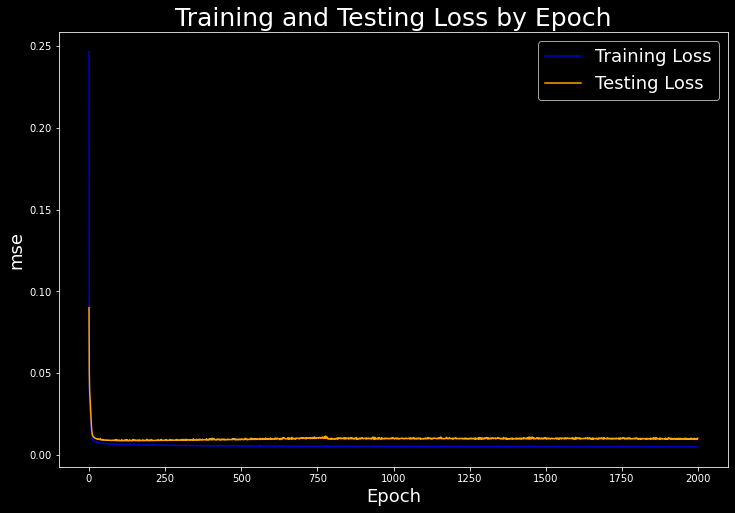

In [59]:
plt.style.use('dark_background')
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color=colors.to_rgba('b',0.8))
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('mse', fontsize = 18)

plt.legend(fontsize = 18);

In [61]:
model.predict(X_test).flatten()

array([0.41212705, 0.36023986, 0.38548124, ..., 0.85257006, 0.8339382 ,
       0.8100111 ], dtype=float32)

In [70]:
results = list(model.predict(X_train).flatten())+list(model.predict(X_test).flatten())

In [69]:
len(_)

4976

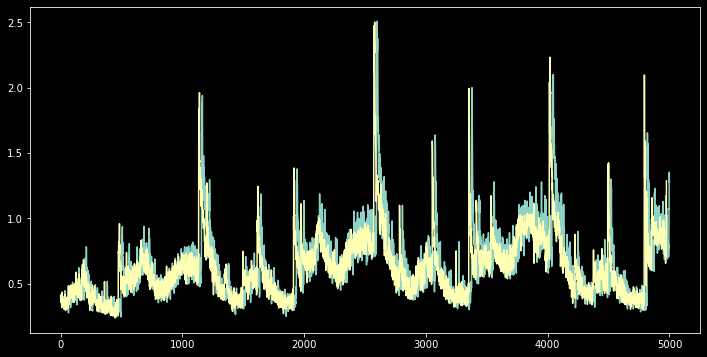

In [80]:
plt.figure(figsize=(12,6))
plt.plot(tweet_rate_df[0][:5000])
plt.plot(results)